## Deep Learning with PyTorch : Neural Style Transfer

## Task 1 : Set Google Colab runtime

![](https://archive.org/download/deep-learning-with-py-torch/Deep%20Learning%20with%20PyTorch.png)

In [ ]:
!pip install torch torchvision

In [ ]:
!git clone https://github.com/parth1620/Project-NST.git

## Task 2 : Loading VGG Pretrained Model

In [ ]:
import torch
from torchvision import models

vgg = models.vgg19(pretrained = True)
print(vgg)

In [ ]:
vgg = vgg.features
print(vgg)

In [ ]:
for param in vgg.parameters():
  param.requires_grad_(False)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
vgg.to(device)

## Task 3 : Preprocess image

Torchvision models page : https://pytorch.org/docs/stable/torchvision/models.html

In [ ]:
from PIL import Image
from torchvision import transforms as T

def preprocess(img_path, max_size = 500):
  image = Image.open(img_path).convert('RGB')
  if max(image.size) > max_size:
    size = max_size
  else:
    size = max(image.size)
  img_transforms = T.Compose([
      T.Resize(size),
      T.ToTensor(), #(224, 224, 3) -> (3, 224, 224)
      T.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
  ])
  image = img_transforms(image)
  image = image.unsqueeze(0) #(3, 224, 224) -> (1, 3, 224, 224)
  return image

In [ ]:
content_p = preprocess('/content/Project-NST/content11.jpg')
style_p = preprocess('/content/Project-NST/style12.jpg')
content_p = content_p.to(device)
style_p = style_p.to(device)
print('Content Shape', content_p.shape)
print('Style shape', style_p.shape)

Content Shape torch.Size([1, 3, 259, 345])
Style shape torch.Size([1, 3, 625, 500])


## Task 4 : Deprocess image

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def deprocess(tensor):
  image = tensor.to('cpu').clone()
  image = image.numpy()
  image = image.squeeze(0) # (1, 3, 224, 224) -> (3, 224, 224)
  image = image.transpose(1, 2, 0) #(3, 224, 224) -> (224, 224, 3)
  image = image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
  image = image.clip(0, 1)
  return image

In [ ]:
content_d = deprocess(content_p)
style_d = deprocess(style_p)
print('Deprocess content shape: ', content_d.shape)
print('Deprocess style shpe:', style_d.shape)

Deprocess content shape:  (259, 345, 3)
Deprocess style shpe: (625, 500, 3)


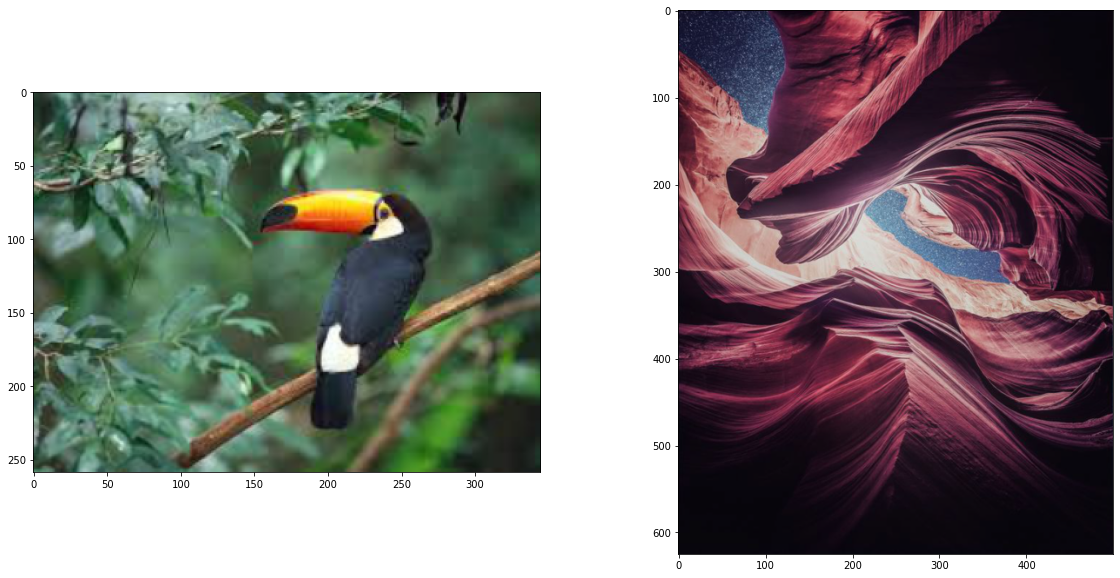

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))
ax1.imshow(content_d)
ax2.imshow(style_d)

## Task 5 : Get content,style features and create gram matrix

In [ ]:
def get_features(image, model):
  layers = {
      '0' : 'conv1_1',
      '5' : 'conv2_1',
      '10' : 'conv3_1',
      '19' : 'conv4_1',
      '21' : 'conv4_2', # content_feature
      '28' : 'conv5_1'
  }

  x = image
  Features = {}
  for name, layer in model._modules.items():
    x = layer(x)
    if name in layers:
      Features[layers[name]] = x
  return Features


In [ ]:
content_f = get_features(content_p, vgg)
style_f = get_features(style_p, vgg)

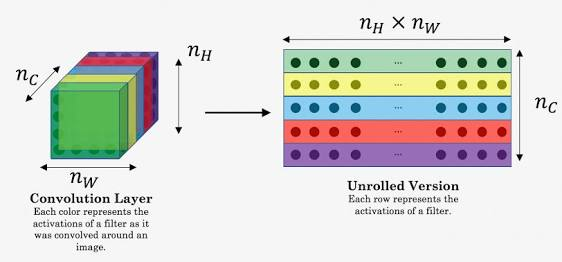

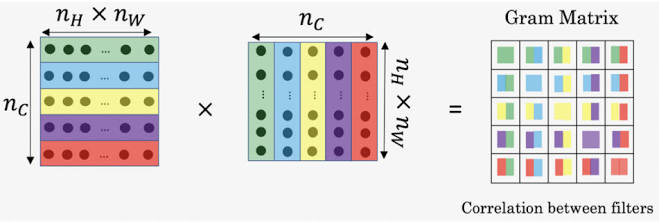

In [ ]:
def gram_matrix(tensor):
  b, c, h, w = tensor.size()
  tensor = tensor.view(c, h*w)
  gram = torch.mm(tensor, tensor.t())
  return gram

In [ ]:
style_grams = {layer : gram_matrix(style_f[layer]) for layer in style_f}

## Task 6 : Creating Style and Content loss function

In [ ]:
def content_loss(target_conv4_2, content_conv4_2):
  loss = torch.mean((target_conv4_2 - content_conv4_2)**2)
  return loss

In [ ]:
style_weights = {
    'conv1_1' : 1.0,
    'conv2_1' : 0.7,
    'conv3_1' : 0.2,
    'conv4_1' : 0.2,
    'conv5_1' : 0.2
}

def style_loss(style_weights, target_features, style_grams):
  loss = 0
  for layer in style_weights:
    target_f = target_features[layer]
    target_gram = gram_matrix(target_f)
    style_gram = style_grams[layer]
    b, c, h, w = target_f.shape
    layer_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
    loss += layer_loss / (c*h*w)
  return loss 

In [ ]:
target = content_p.clone().requires_grad_(True).to(device)
target_f = get_features(target, vgg)
print('Content loss:', content_loss(target_f['conv4_2'], content_f['conv4_2']))
print('Style loss:', style_loss(style_weights, target_f, style_grams))

Content loss: tensor(0., device='cuda:0', grad_fn=<MeanBackward0>)
Style loss: tensor(1732.1233, device='cuda:0', grad_fn=<AddBackward0>)


## Task 7 : Training loop

In [ ]:
from torch import optim
optimizer = optim.Adam([target], lr = 0.003)
alpha = 1
beta = 1e5
epochs = 3000
show_every = 500

In [ ]:
def total_loss(c_loss, s_loss, alpha, beta):
  loss = alpha * c_loss + beta * s_loss
  return loss

In [ ]:
results = []
for i in range(epochs):
  target_f = get_features(target, vgg)
  c_loss = content_loss(target_f['conv4_2'], content_f['conv4_2'])
  s_loss = style_loss(style_weights, target_f, style_grams)
  t_loss = total_loss(c_loss, s_loss, alpha, beta)
  optimizer.zero_grad()
  t_loss.backward()
  optimizer.step()

  if i % show_every == 0:
    print(f'Total loss at Epoch {i} : {t_loss}')
    results.append(deprocess(target.detach()))

Total loss at Epoch 0 : 173212336.0
Total loss at Epoch 500 : 26193808.0
Total loss at Epoch 1000 : 14746964.0
Total loss at Epoch 1500 : 11384798.0
Total loss at Epoch 2000 : 9368454.0
Total loss at Epoch 2500 : 7989344.0


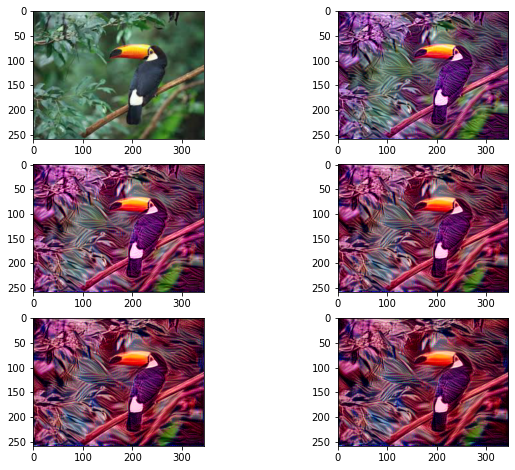

In [ ]:
plt.figure(figsize = (10, 8))
for i in range(len(results)):
  plt.subplot(3, 2, i + 1)
  plt.imshow(results[i])
plt.show()

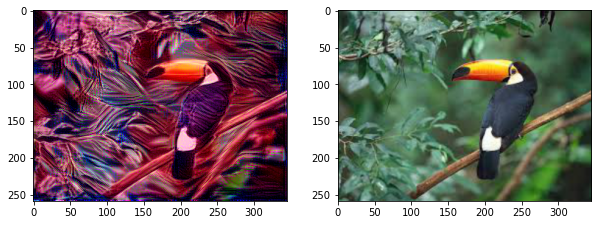

In [ ]:
target_copy = deprocess(target.detach())
content_copy = deprocess(content_p)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
ax1.imshow(target_copy)
ax2.imshow(content_copy)